# Multimodal Siamese Network

### Movie Genre Classification using Poster Images and Plot Descriptions

This Notebook uses a pre-existing dataset of movie poster images and a csv of corresponding plot text descriptions to make a multi-modal model to judge class similarity between pairs of movies using their posters and descriptions. 

In [1]:
import os

data_dir = '/kaggle/input/imdb-multimodal-vision-and-nlp-genre-classification/IMDB four_genre_posters'
doc_types = os.listdir(data_dir)

paths = []
for i in doc_types:
    paths.append(os.path.join(data_dir,i))

print(doc_types)

['Comedy', 'Horror', 'Romance', 'Action']


In [2]:
import csv

csv_file = '/kaggle/input/imdb-multimodal-vision-and-nlp-genre-classification/IMDB_four_genre_larger_plot_description.csv'

image_descriptions = {}

with open(csv_file, 'r') as csvfile:
    csv_reader = csv.DictReader(csvfile)
    for row in csv_reader:
        title = row['movie_id']
        description = row['description']
        image_descriptions[title] = description        

In [3]:
image_size = (84, 84)
def load_image(image_path, target_size=image_size):
    """
    Load an image from the given path, resize it to the target size,
    and normalize it.
    """
    try:
        # read image, convert it to grayscale, resize and normalize
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, target_size)
            image_norm = image / 255.0
            return image_norm
        else:
            print(f"Failed to load image: {image_path}")
            return None
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None

In [4]:
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf

2024-03-28 08:32:58.265173: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 08:32:58.265308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 08:32:58.387769: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
def load_data(directory):
    # data will hold processed, normalized images
    data = []
    dataID = []
    # labels will hold class number
    labels = []
    classes = ['Comedy', 'Horror', 'Romance', 'Action']
    # create a label encoder
    label_encoder = LabelEncoder()
    label_encoder.fit(classes)
    count = 0
    class_to_label = dict(zip(classes, label_encoder.transform(classes)))
    print("Class to Label Mapping:")
    print(class_to_label)
    # iterate through the classes in the data folder
    for class_num in classes:
        # path to images in current class
        path = os.path.join(directory, class_num)
        # iterate through all images in the class
        for image_num in os.listdir(path):
            image_path = os.path.join(path, image_num)
            # load the image
            image = load_image(image_path)
            title = str(image_num.split(".")[0])
            if image is not None:
                if title in image_descriptions:
                    data.append(image)
                    dataID.append(title)
                    # encode class name to numerical label
                    label = label_encoder.transform([class_num])[0]
                    labels.append(label)
    return np.array(data), np.array(labels), np.array(dataID)

In [6]:
data, labels, ids = load_data(data_dir)

Class to Label Mapping:
{'Comedy': 1, 'Horror': 2, 'Romance': 3, 'Action': 0}


In [7]:
print(data.shape, labels.shape, ids.shape)

(724, 84, 84) (724,) (724,)


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Extract descriptions for the image IDs
descriptions = [image_descriptions[id] for id in ids]

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(descriptions)
word_index = tokenizer.word_index

# Vocabulary size
vocab_size = len(word_index) + 1  # Adding 1 for the padding token

# Convert text descriptions to sequences of tokens
sequences = tokenizer.texts_to_sequences(descriptions)

# Padding sequences to ensure uniform length
max_sequence_length = 375  # Example sequence length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Print the vocabulary size and an example padded sequence
print("Vocabulary size:", vocab_size)

Vocabulary size: 21025


In [9]:
print(data.shape, labels.shape, padded_sequences.shape)

(724, 84, 84) (724,) (724, 375)


tt12593682 1
Five assassins aboard a swiftly-moving bullet train find out that their missions have something in common. Unlucky assassin Ladybug (Brad Pitt) is determined to do his job peacefully after one too many gigs has gone off the rails. Fate has other plans, however: Ladybug's latest mission puts him on a collision course with lethal adversaries from around the globe--all with connected, yet conflicting, objectives--on the world's fastest train. The end of the line is just the beginning in this non-stop thrill-ride through modern-day Japan. Experiencing unprecedented calmness thanks to newfound spiritual enlightenment, retired assassin Ladybug gets back in the game with a straightforward mission: snatch an aluminium attachÃƒÂƒÃ‚Â© case from a speedy Shinkansen train bound for Kyoto, and return it to its owner in one piece. However, there's always a catch to great-sounding deals. As five vicious hitmen vie for the same silver briefcase, hidden agendas get in the way, and everythi

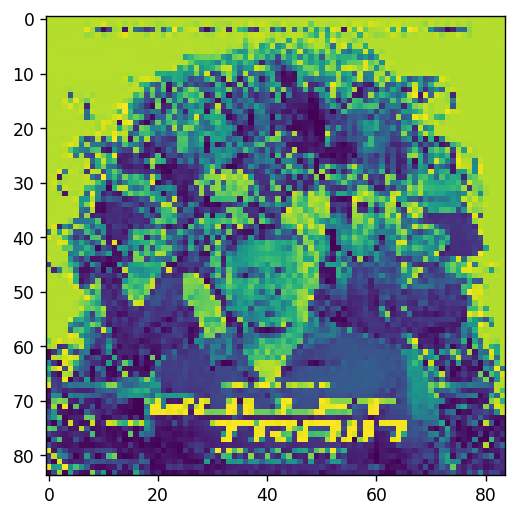

In [10]:
import matplotlib.pyplot as plt
img_A = data[0]
plt.figure(dpi=124)
plt.imshow(img_A)
print (ids[0], labels[0])
print(image_descriptions[ids[0]])

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

input_size = 84
embedding_dim = 200

img_A_inp = Input((input_size, input_size), name='img_A_inp')
img_B_inp = Input((input_size, input_size), name='img_B_inp')
desc_A_inp = Input((max_sequence_length,), name='desc_A_inp')
desc_B_inp = Input((max_sequence_length,), name='desc_B_inp')

# CNN block
def get_cnn_block(depth, kernel_regularizer=None):
    return Sequential([
        Conv2D(depth, 3, 1, kernel_regularizer=kernel_regularizer, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2)
    ])

DEPTH = 64
kernel_regularizer = regularizers.l2(0.01)

cnn = Sequential([
    Reshape((input_size, input_size, 1)),
    get_cnn_block(DEPTH, kernel_regularizer=kernel_regularizer),
    get_cnn_block(DEPTH*2, kernel_regularizer=kernel_regularizer),
    get_cnn_block(DEPTH*4, kernel_regularizer=kernel_regularizer),
    get_cnn_block(DEPTH*8, kernel_regularizer=kernel_regularizer),
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)
])

# LSTM block
lstm = Sequential([
    Embedding(vocab_size, embedding_dim),
    Dropout(0.2), 
     LSTM(64, kernel_regularizer=kernel_regularizer, dropout=0.2, recurrent_dropout=0.2)
])

# Process images and descriptions
feature_vector_A = cnn(img_A_inp)
feature_vector_B = cnn(img_B_inp)
desc_vector_A = lstm(desc_A_inp)
desc_vector_B = lstm(desc_B_inp)

# Concatenate image and description features
concat = Concatenate()([feature_vector_A, feature_vector_B, desc_vector_A, desc_vector_B])

dense = Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)(concat)
dense = BatchNormalization()(dense)  # Batch normalization added
dense = Dropout(0.5)(dense)  # You might consider increasing dropout
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[img_A_inp, img_B_inp, desc_A_inp, desc_B_inp], outputs=output)

model.summary()

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_A_inp           │ (None, 84, 84)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_B_inp           │ (None, 84, 84)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ desc_A_inp          │ (None, 375)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ desc_B_inp          │ (None, 375)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 64)        │  1,586,496 │ img_A_inp[0][0],  │
│ (Sequential)        │                   │            │ img_B_inp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 64)        │  4,272,840 │ desc_A_inp[0][0], │
│ (Sequential)        │                   │            │ desc_B_inp[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ sequential_4[0][… │
│ (Concatenate)       │                   │            │ sequential_4[1][… │
│                     │                   │            │ sequential_5[0][… │
│                     │                   │            │ sequential_5[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     16,448 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,876,105 (22.42 MB)

 Trainable params: 5,874,057 (22.41 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [12]:
dataset_size = len(data)

train_ratio = 0.8

indices = np.arange(dataset_size)
np.random.shuffle(indices)

train_size = int(dataset_size * train_ratio)
train_indices, test_indices = indices[:train_size], indices[train_size:]

train_images, test_images = data[train_indices], data[test_indices]
train_descriptions, test_descriptions = padded_sequences[train_indices], padded_sequences[test_indices]
train_labels, test_labels = labels[train_indices], labels[test_indices]

print(train_images.shape, train_descriptions.shape, train_labels.shape)
print(test_images.shape, test_descriptions.shape, test_labels.shape)

(579, 84, 84) (579, 375) (579,)
(145, 84, 84) (145, 375) (145,)


In [13]:
import numpy as np

random_indices = np.random.choice(train_images.shape[0], 250, replace=False)

X_train_sample, desc_sample, y_train_sample = train_images[random_indices], train_descriptions[random_indices], train_labels[random_indices]

X_train_sample.shape, desc_sample.shape, y_train_sample.shape

((250, 84, 84), (250, 375), (250,))

In [14]:
random_indices = np.random.choice(test_images.shape[0], 100, replace=False)

X_test_sample, desc_test_sample, y_test_sample = test_images[random_indices], test_descriptions[random_indices], test_labels[random_indices]

X_test_sample.shape, desc_test_sample.shape, y_test_sample.shape

((100, 84, 84), (100, 375), (100,))

In [15]:
import itertools

def make_paired_dataset(X, D, y):
    X_pairs, D_pairs, y_pairs = [], [], []

    tuples = [(x1, d1, y1) for x1, d1, y1 in zip(X, D, y)]

    for t in itertools.product(tuples, tuples):
        pair_A, pair_B = t
        img_A, desc_A, label_A = t[0]
        img_B, desc_B, label_B = t[1]

        new_label = int(label_A == label_B)

        X_pairs.append([img_A, img_B])
        D_pairs.append([desc_A, desc_B])
        y_pairs.append(new_label)

    X_pairs = np.array(X_pairs)
    D_pairs = np.array(D_pairs)
    y_pairs = np.array(y_pairs)

    return X_pairs, D_pairs, y_pairs

In [16]:
X_train_pairs, desc_train_pairs, y_train_pairs = make_paired_dataset(X_train_sample, desc_sample, y_train_sample)
X_train_pairs.shape, desc_train_pairs.shape, y_train_pairs.shape

((62500, 2, 84, 84), (62500, 2, 375), (62500,))

In [17]:
X_test_pairs, desc_test_pairs, y_test_pairs = make_paired_dataset(X_test_sample, desc_test_sample, y_test_sample)
X_test_pairs.shape, desc_test_pairs.shape, y_test_pairs.shape

((10000, 2, 84, 84), (10000, 2, 375), (10000,))

In [ ]:
model.fit(
        x=[X_train_pairs[:, 0, :, :], X_train_pairs[:, 1, :, :], 
           desc_train_pairs[:, 0, :], desc_train_pairs[:, 1, :]],
        y=y_train_pairs,
        epochs=10,
        validation_data=([X_test_pairs[:, 0, :, :], X_test_pairs[:, 1, :, :], 
                          desc_test_pairs[:, 0, :], desc_test_pairs[:, 1, :]],
                           y_test_pairs),
        callbacks=[lr_scheduler, early_stopping])

Epoch 1/10


2024-03-28 08:33:37.634703: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_7_1/sequential_4_3/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1954/1954 ━━━━━━━━━━━━━━━━━━━━ 1721s 874ms/step - accuracy: 0.6712 - loss: 2.3265 - val_accuracy: 0.7058 - val_loss: 0.6639 - learning_rate: 0.0010
Epoch 2/10
1126/1954 ━━━━━━━━━━━━━━━━━━━━ 11:30 833ms/step - accuracy: 0.7187 - loss: 0.6477

In [ ]:
a = 3
b = 3
img_A, img_B = test_images[a], test_images[b]
desc_A, desc_B = test_descriptions[a], test_descriptions[b]
label_A, label_B = test_labels[a], test_labels[b]

label_A, label_B

In [ ]:
import matplotlib.pyplot as plt

plt.figure(dpi=84)
plt.imshow(img_A)

In [ ]:
plt.figure(dpi=84)
plt.imshow(img_B)

In [ ]:
val=model.predict([img_A.reshape((1, input_size, input_size)), 
               img_B.reshape((1, input_size, input_size)),
               desc_A.reshape((1,350)),
               desc_B.reshape((1,350))
              ]).flatten()[0]
if val > 0.5:
    print("These are of the same class")
else:
    print("These are of different classes")

In [ ]:
model.save('/kaggle/working/model.keras')